In [29]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sympy import *
from scipy.optimize import linprog
from copy import deepcopy
from sympy.plotting import plot
from sympy.plotting import plot3d
from IPython.display import display, HTML


def branche_boundaries(F: str, constraint: list):
    '''
    inputs:
        F: function as a string (example: '2*x1 + 6*x2')
        constraint: restrictions in the form of a list of strings (example: ['x1 - x2 <= 4', '-3*x1 <= 17'])
    outputs:
        tuple: (point, result of function);
        example: (array([1., 5.]), 4.00000000000000)
    '''
    dataset = []
    exp = sympify(F)
    
    
    count_constraint = int(input('Введите количество ограничений: '))
    
    symbs = sorted(list(exp.free_symbols), key=lambda x: str(x))
    
    c = [float(exp.coeff(symb)) for symb in symbs]
    
    dic_constr = {i: [] for i in range(1, count_constraint+1)}
    for i in range(len(constraint)):
        ineq = sympify(constraint[i])
        ex = ineq.args[0]
        dic_constr[i+1] = [float(ex.coeff(symb)) for symb in symbs]

    A = [v for v in dic_constr.values()]
    
    for i in range(len(symbs)):
        lst = [0.0]*len(symbs)
        lst[i] = -1.0
        A.append(lst)
    
    b = []
    for ineq in constraint:
        ine = sympify(ineq)
        b.append(ine.args[1])
    
    b += [0]*len(symbs)
    
    res = linprog(c, A_ub=A, b_ub=b, method='simplex')['x']
    dataset.append([res, exp.subs(list(zip(symbs, res)))])
    
    if all(str(i).split('.')[-1] == '0' for i in res) \
            and all([sympify(const).subs(list(zip(symbs, res))) for const in constraint]):
        # draw 
        first_point = solve([exp, constraint[0].replace('<=', '-')], list(symbs), dict=True)
        
        return res, exp.subs(list(zip(symbs, res))), dataset, first_point
    
    try:
        res_zlp1 = ZLP1(F, constraint, res, symbs, A, b, c, dataset)
    except:
        res_zlp1 = None
        
    try:
        res_zlp2 = ZLP2(F, constraint, res, symbs, A, b, c, dataset)
    except:
        res_zlp2 = None
    
    if res_zlp1 is not None and res_zlp2 is not None:
        if exp.subs(list(zip(symbs, res_zlp1))) <= exp.subs(list(zip(symbs, res_zlp2))):
            return res_zlp1, exp.subs(list(zip(symbs, res_zlp1))), dataset
        else:
            return res_zlp2, exp.subs(list(zip(symbs, res_zlp2))), dataset
    elif res_zlp1 is not None and res_zlp2 is None:
        return res_zlp1, exp.subs(list(zip(symbs, res_zlp1))), dataset
    elif res_zlp1 is None and res_zlp2 is not None:
        return res_zlp2, exp.subs(list(zip(symbs, res_zlp2))), dataset
    else:
        return None, dataset
    
def ZLP1(func, constraint, res_last, symbs, A, b, c, dataset):
    i = np.argmax(res_last%1)
    whole = int(res_last[i])
    lst = [0]*len(symbs)
    lst[i] = 1
    
    
    A_new = deepcopy(A)
    b_new = deepcopy(b)
    A_new.append(lst)
    b_new.append(whole)

    res = linprog(c, A_ub=A_new, b_ub=b_new, method='simplex')['x']
    dataset.append([list(res[0])], res[1])
    
    
    if all(str(i).split('.')[-1] == '0' for i in res) \
            and all([sympify(const).subs(list(zip(symbs, res))) for const in constraint]):
        return res
    
    res_zlp3 = ZLP1(func, constraint, res, symbs, A_new, b_new, c)
    res_zlp4 = ZLP2(func, constraint, res, symbs, A_new, b_new, c)
    
    
    to_return = []
    if all(str(i).split('.')[-1] == '0' for i in res_zlp3) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp3))) for const in constraint]):
        to_return.append(res_zlp3)
    if all(str(i).split('.')[-1] == '0' for i in res_zlp4) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp4))) for const in constraint]):
        to_return.append(res_zlp4)
        
    if to_return:
        return to_return
    else:
        return None

def ZLP2(func, constraint, res_last, symbs, A, b, c, dataset):
    i = np.argmax(res_last%1)
    whole = -int(res_last[i])-1 
    lst = [0]*len(symbs)
    lst[i] = 1
    
    A_new = deepcopy(A)
    b_new = deepcopy(b)
    A_new.append(lst)
    b_new.append(whole)

    res = linprog(c, A_ub=A_new, b_ub=b_new, method='simplex')['x']
    dataset.append([list(res[0])], res[1])
    
    if all(str(i).split('.')[-1] == '0' for i in res) \
            and all([sympify(const).subs(list(zip(symbs, res))) for const in constraint]):
        return res
    
    res_zlp5 = ZLP1(func, constraint, res, symbs, A_new, b_new, c)
    res_zlp6 = ZLP2(func, constraint, res, symbs, A_new, b_new, c)
    
    to_return = []
    if all(str(i).split('.')[-1] == '0' for i in res_zlp5) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp5))) for const in constraint]):
        to_return.append(res_zlp5)
    if all(str(i).split('.')[-1] == '0' for i in res_zlp5) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp5))) for const in constraint]):
        to_return.append(res_zlp6)
        
    if to_return:
        return to_return
    else:
        return None

In [30]:
example = branche_boundaries('-x + y - 1', ['2*x + 3*y <= 12', '3*x + 2*y <= 12'])

Введите количество ограничений: 2


In [31]:
x = np.linspace(0, 9/5)

In [32]:
y = 1 + x

In [33]:
x2 = np.linspace(9/5, 12/5)

In [34]:
y2 = (-2*x2 + 12)/3

In [35]:
x3 = np.linspace(12/5, 4)

In [36]:
y3 = (-3*x3+12)/2

In [37]:
x_test = list(x) + list(x2) + list(x3)
y_test = list(y) + list(y2) + list(y3)

In [38]:
limit_y1 = list(np.linspace(0, min(y)))
limit_x1 = [0]*len(limit_y1)

In [39]:
limit_x2 = list(np.linspace(0, max(x_test)))
limit_y2 = [0]*len(limit_x2)


In [40]:
coordinates = {'x': [], 
               'y': []}

In [41]:
x_min, x_max = int(min(x_test)), int(max(x_test))
y_min, y_max = int(min(y_test)), int(max(y_test))

In [42]:
x_test.append(limit_x2)
y_test.append(limit_y2)

In [43]:
x_test = x_test[:-1]

In [44]:
y_test = y_test[:-1]

In [45]:
all_points = list(zip(x_test, y_test))
for i in range(x_min, x_max + 1):
    if i == 0:
        max_y = max(limit_y1)
        for j in range(int(max_y) + 1):
            if j % 1 == 0:
                coordinates['x'].append(i)
                coordinates['y'].append(j)
    else:
        max_y = 0
        for points in all_points:
            if round(points[0]) > 0:
                if int(points[0]) == i:
                    if points[1] > max_y:
                        max_y = points[1]
                        
        for j in range(x_min, int(max_y) + 1):
            if j % 1 == 0:
                coordinates['x'].append(i)
                coordinates['y'].append(j)
        
        if i > int(max_y):
            coordinates['x'].append(i)
            coordinates['y'].append(int(max_y))
        

In [46]:
last_line = {'x': [], 'y': []}

for i in range(len(coordinates['x'])):
    if i == len(coordinates['x']) - 1:
        last_line['x'].append(coordinates['x'][i])
        last_line['y'].append(coordinates['y'][i])
        break
    
    if coordinates['x'][i + 1] == coordinates['x'][i]:
        continue
    else:
        last_line['x'].append(coordinates['x'][i])
        last_line['y'].append(coordinates['y'][i])
    
    
    
    

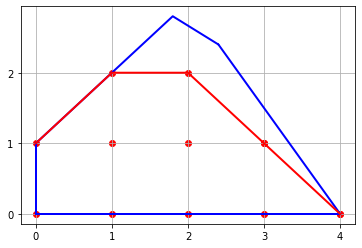

In [47]:
# plot
fig, ax = plt.subplots()

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

ax.plot(limit_x1, limit_y1, linewidth=2.0, c='b')
ax.plot(x_test, y_test, linewidth=2.0, c='b') 
ax.plot(limit_x2, limit_y2, linewidth=2.0, c='b')
ax.scatter(coordinates['x'], coordinates['y'], c='r')
ax.plot(last_line['x'], last_line['y'], linewidth=2.0, c='r')
ax.grid()

plt.show()